# Section 3: Embedding

## Word Embedding on Hamshahri Newspaper dataset

In this section, we want to try different Word Embedding methods. We work on the Hamshahri dataset that is preprocessed in the previous notebook.(Text_Classification.ipynb)

In the beginning, we load the dataset and take a look at the length of texts in it. Then we create an LSTM model for it because based on our result, LSTM models are good for text classification and sentiment analysis. Then try to print word embedding for a few words from the embedding layer in our model and try other embedding methods(e.g. Gensim and Fasttext)

In [3]:
!pip install python-bidi
!pip install arabic-reshaper

In [4]:
# plot
import matplotlib.pyplot as plt

import pandas as pd
import string
import re
import numpy as np
np.random.seed(0)

# libraries for show persian words in correct way(right to left)
from bidi.algorithm import get_display
from arabic_reshaper import reshape

import warnings
warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read dataset

In [ ]:
#load the preprocessing dataframe
ham_train = pd.read_csv('/content/drive/MyDrive/AI-Internship/preprocessed_data/train.csv')
ham_valid = pd.read_csv('/content/drive/MyDrive/AI-Internship/preprocessed_data/valid.csv')
ham_test = pd.read_csv('/content/drive/MyDrive/AI-Internship/preprocessed_data/test.csv')

In [ ]:
print(f'ham train shape: {ham_train.shape}')
print(f'ham valid shape: {ham_valid.shape}')
print(f'ham test shape: {ham_test.shape}')

ham train shape: (8724, 2)
ham valid shape: (2181, 2)
ham test shape: (2727, 2)


In [ ]:
ham_train.head()

,preprocessing_text,label
0,مخبر کمیسیون امنیت ملی سیاست خارجی مجلس نسبت ا...,3
1,علی تاجرنیا نماینده مشهد مجلس انتقاد محاکمه سی...,3
2,عضو کمیسیون صنایع معادن مجلس شورا اسلامی منظور...,2
3,دریابان علی شمخانی وزیر دفاع جمهوری اسلامی ایر...,3
4,گردهمایی کارشناس کارکنان سازمان دانش آموخت&آمو...,4


label encoding (based on lexical order):

    سیاسی -> 3
    اقتصاد -> 2
    اجتماعی-> 0
    ورزش -> 5
    علمی فرهنگی -> 4
    ادب و هنر -> 1


In [ ]:
ham_train.label.value_counts()

3    2086
2    1917
5    1379
0    1350
4    1253
1     739
Name: label, dtype: int64

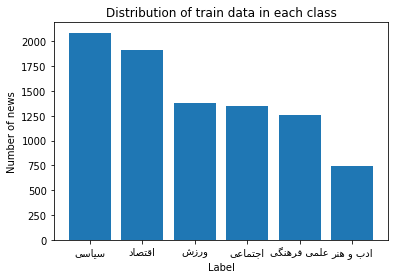

In [ ]:
# destribution of data in each class
distribution  = list(ham_train.label.value_counts())

classes = ['سیاسی','اقتصاد','ورزش','اجتماعی','علمی فرهنگی','ادب و هنر'] 
classes = [get_display(reshape(label)) for label in classes]

plt.bar(classes, distribution)
plt.xlabel("Label")
plt.ylabel("Number of news")
plt.title("Distribution of train data in each class")
plt.show()

In [ ]:
ham_valid.label.value_counts()

2    519
3    511
5    332
0    323
4    312
1    184
Name: label, dtype: int64

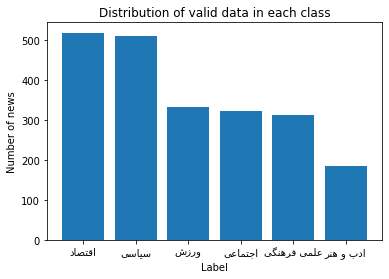

In [ ]:
# destribution of data in each class
distribution  = list(ham_valid.label.value_counts())

classes = ['اقتصاد','سیاسی','ورزش','اجتماعی','علمی فرهنگی','ادب و هنر'] 
classes = [get_display(reshape(label)) for label in classes]

plt.bar(classes, distribution)
plt.xlabel("Label")
plt.ylabel("Number of news")
plt.title("Distribution of valid data in each class")
plt.show()

In [ ]:
ham_test.label.value_counts()

3    622
2    598
0    462
4    404
5    402
1    239
Name: label, dtype: int64

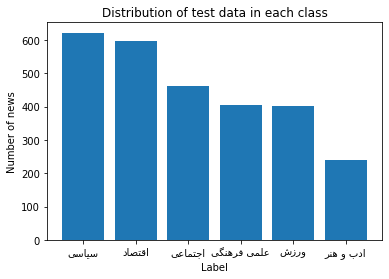

In [ ]:
# destribution of data in each class
distribution  = list(ham_test.label.value_counts())

classes = ['سیاسی','اقتصاد','اجتماعی','علمی فرهنگی', 'ورزش','ادب و هنر'] 
classes = [get_display(reshape(label)) for label in classes]

plt.bar(classes, distribution)
plt.xlabel("Label")
plt.ylabel("Number of news")
plt.title("Distribution of test data in each class")
plt.show()

As we see in the following cell, we have on missing value in our text column, So in order to calculate text length, we should drop this row.

In [ ]:
ham_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8724 entries, 0 to 8723
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   preprocessing_text  8723 non-null   object
 1   label               8724 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 136.4+ KB


In [ ]:
df = ham_train.copy()
ham_train = df.dropna()

In [ ]:
ham_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8723 entries, 0 to 8723
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   preprocessing_text  8723 non-null   object
 1   label               8723 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 204.4+ KB


In [ ]:
# ham_train.to_csv('/content/drive/MyDrive/AI-Internship/preprocessed_data/train_updated.csv', index=False)

Let's take a look at length of texts in dataset.

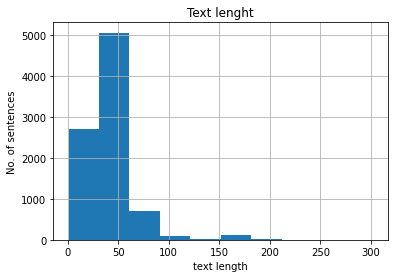

count    8723.000000
mean       42.027743
std        22.978069
min         1.000000
25%        29.000000
50%        38.000000
75%        48.000000
max       302.000000
dtype: float64

In [ ]:
text_len = [len(i.split()) for i in ham_train.preprocessing_text.values]
pd.Series(text_len).hist()
plt.title('Text lenght')
plt.xlabel('text length')
plt.ylabel('No. of sentences')
plt.show()
pd.Series(text_len).describe()

### Prepare Dataset for Neural Network

In [6]:
import torch
import torchtext
from torchtext.legacy import data
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.optim import lr_scheduler
from torch.utils.data.dataset import random_split

from sklearn.metrics import classification_report
from torchtext.vocab import Vectors
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

#Reproducing same results
SEED = 2019
torch.manual_seed(SEED)

#### Load the custom dataset using PyTorchText TabularDataset

In [7]:
# define pipline for text and label columns
TEXT = data.Field(tokenize='spacy',
                  include_lengths=True, batch_first=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

In [8]:
fields = [('preprocessing_text',TEXT), ('label', LABEL)]

In [9]:
train_data = data.TabularDataset(path='/content/drive/MyDrive/AI-Internship/preprocessed_data/train_updated.csv'
                                , format='csv', fields=fields, skip_header=True)

valid_data = data.TabularDataset(path='/content/drive/MyDrive/AI-Internship/preprocessed_data/valid.csv'
                                , format='csv', fields=fields, skip_header=True)

test_data = data.TabularDataset(path='/content/drive/MyDrive/AI-Internship/preprocessed_data/test.csv'
                                , format='csv', fields=fields, skip_header=True)


In [10]:
len(train_data)

8723

#### Construct Vocabulary

In [11]:
TEXT.build_vocab(train_data, valid_data,min_freq=3 )
LABEL.build_vocab(train_data, valid_data)

In [ ]:
#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))
print("Size of TEXT vocabulary:",len(LABEL.vocab))
print(" ")
print('-'*200)

#Commonly used words
print(f'10 commonly used words : {TEXT.vocab.freqs.most_common(10)}')  
print(" ")
print('-'*200)

#Word dictionary
print(f'word dictionary : {TEXT.vocab.stoi}') 

Size of TEXT vocabulary: 9802
Size of TEXT vocabulary: 6
 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
10 commonly used words : [('ایران', 6568), ('کشور', 5182), ('اسلامی', 4086), ('سال', 3229), ('تهران', 3182), ('رئیس', 2631), ('شورا', 2613), ('تیم', 2487), ('جمهوری', 2458), ('گزارش', 2203)]
 
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
word dictionary : defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f3be4db5390>>, {'<unk>': 0, '<pad>': 1, 'ایران': 2, 'کشور': 3, 'اسلامی': 4, 'سال': 5, 'تهران': 6, 'رئیس': 7, 'شورا': 8, 'تیم': 9, 'جمهوری': 10, 'گزارش': 11, 'سازمان': 12, 'مجلس': 13, 'ملی': 14, 'شرکت': 15, 'شهر': 16, 'سرمایه\u200cگ

In [12]:
vocab_size = len(TEXT.vocab)
batch_size = 8
embed_dim = 128
num_class = 6

print(f'vocab size : {vocab_size}')

vocab size : 9802


In the following cell, we check that which device we are using. Then we should migrate our variables and models on it.

https://towardsdatascience.com/pytorch-switching-to-the-gpu-a7c0b21e8a99

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [14]:
# create dataloader
train_loader = data.BucketIterator(train_data, batch_size, sort_key= lambda x: len(x.preprocessing_text),
                                  train=True, shuffle=True, sort_within_batch=True, device=device)

valid_loader = data.BucketIterator(valid_data, batch_size, sort_key= lambda x: len(x.preprocessing_text),
                                  train=False, shuffle=False, sort_within_batch=True, device=device)

test_loader = data.BucketIterator(test_data, batch_size, sort_key= lambda x: len(x.preprocessing_text),
                                  train=False, shuffle=False, sort_within_batch=True, device=device)


In [15]:
print(f'length of train_dataset is : {len(train_data)} and length of train_loader is : {len(train_loader)}')
print(f'length of valid_dataset is : {len(valid_data)} and length of valid_loader is : {len(valid_loader)}')
print(f'length of test_dataset is : {len(test_data)} and length of test_loader is : {len(test_loader)}')

length of train_dataset is : 8723 and length of train_loader is : 1091
length of valid_dataset is : 2181 and length of valid_loader is : 273
length of test_dataset is : 2727 and length of test_loader is : 341


Let's take a look at one batch of train_loader.


In [ ]:
for batches in train_loader:
  print(f'batch size : {len(batches)}')
  print(batches)
  x, y = batches.preprocessing_text
  print(f'text : {x}')
  print(f'text shape : {x.shape}')
  print(f'len(text) : {len(x)}')
  print(f'text length : {y}')
  print(f'label : {batches.label}')
  break

batch size : 8

[torchtext.legacy.data.batch.Batch of size 8]
	[.preprocessing_text]:('[torch.LongTensor of size 8x29]', '[torch.LongTensor of size 8]')
	[.label]:[torch.FloatTensor of size 8]
text : tensor([[ 584,   40,   10,    4,  152, 1013,   72, 7841, 1480,  152, 1013,  303,
         7841,  187,  282,  173, 3584, 1794, 2072,   16,  584, 1299, 1902, 1231,
         4473,  271,  323, 1096,  270],
        [   8,  802,  822,  114,  802,  157,  226,  650,  138, 1612,  802,    6,
          994,  802, 4250, 1125,  822,    8,  802,    0,  313,    8,  802,  822,
          114,  802,  157,  226,  650],
        [ 526,  347,   76, 2108,  538,    2,  636,  429,    5,  925,   82,  124,
            5,   82,   77,   11,   12,  428, 1207,  636,  429,  543,    2,    5,
           82,  124,    5,   58, 8564],
        [7836,    0,    7,   10, 2471,  675, 2100,  799,   36,    6, 4876, 2471,
         6315,  726,  194,  122,    7,   10,    2,    3,  951,  427, 1145,  853,
          122,  194, 2471,  434,

### Building model

**When we define class for LSTM model or CNN model, we should not pass (model_class_name, self) to super. It give us an error when we want to load model.**

In [13]:
class LSTM(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
               num_layers, dropout ):
    super().__init__()
    
    #embedding layer
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    
    #lstm layer
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)

    #dense layer
    self.fc = nn.Linear(hidden_dim*2, output_dim)

  def forward(self, text, text_lengths):
    # text = [batch size, sent_len}
    embedded = self.embedding(text)
    # embedded = [batch_size, sent_len, emd dim]

    packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths, batch_first=True)

    packed_out, (hidden, cell) = self.lstm(packed_embedded)
    #hidden = [batch size, num layers * num directions,hid dim]
    #cell = [batch size, num layers * num directions,hid dim]

    # concat the final forward and backward hidden state
    hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

    # hidden = [batch size, hid dim* num direction]
    outputs = self.fc(hidden)

    
    return outputs


In [14]:
# define hyperparameters
vocab_size = len(TEXT.vocab)
embedding_dim = 128
num_hidden_nodes = 32
num_output_nodes = 6
num_layers = 2
dropout = 0.3

model1 = LSTM(vocab_size, embedding_dim, num_hidden_nodes, 
                           num_output_nodes, num_layers, dropout=dropout)

In [15]:
print(model1)

LSTM(
  (embedding): Embedding(9802, 128)
  (lstm): LSTM(128, 32, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)


In [16]:
num_epoch = 10
learning_rate= 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr = learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, 2, gamma=0.7)


n_total_step = len(train_loader)

In [17]:
# Define a funciton to calculate accuracy for multi class classification model
def multi_class_acc(y_pred, y_act):

  y_pred_softmax = torch.softmax(y_pred, 1)
  _, y_pred_tag = torch.max(y_pred_softmax,1)

  correct = (y_pred_tag == y_act).float()  # Show which elements are the same with 1
  acc = correct.sum()/len(correct)
  acc = torch.round(acc * 100)

  return acc

### Train and Evaluate the model

In [18]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('model_Ham')

In [36]:
# %reload_ext tensorboard
# %tensorboard --logdir 'model_Ham'

In [20]:
# define a function for training a model
def train(model1, train_loader):
  
  train_epoch_loss = 0
  train_epoch_acc = 0
  
  # train the model
  model1.train()

  loop = tqdm(enumerate(train_loader), total = n_total_step, leave = False)

  for i, batch in loop:
    
    optimizer.zero_grad()

    # retrieve text and number of words
    text, text_lengths = batch.preprocessing_text

    # convert to 1D tensor
    y_pred = model1(text, text_lengths).squeeze()

    # because our labels in form of float tensor, we should convert them to long tensor(int)
    label = batch.label.to(torch.long)

    loss_train = criterion(y_pred, label)

    acc_train = multi_class_acc(y_pred, label)

    loss_train.backward()

    optimizer.step()

    train_epoch_loss += loss_train.item()
    train_epoch_acc += acc_train.item()

    loop.set_description(f'Epoch : [{epoch}/{num_epoch}]')
    loop.set_postfix(loss = loss_train.item(), accuracy = acc_train.item()) 
  
  train_loss.append(train_epoch_loss/len(train_loader))
  train_acc.append(train_epoch_acc/len(train_loader))  
      
  # if you want to monitor your model in tensorboard   
  writer.add_scalar('training loss',train_epoch_loss/len(train_loader) , epoch)
  writer.add_scalar('training accuracy',train_epoch_acc/len(train_loader) , epoch)

  return train_loss, train_acc


# define a function for evaluating model
def evaluate(model1, valid_loader):

  # validation
  with torch.no_grad():
    model1.eval()

    val_epoch_loss = 0
    val_epoch_acc = 0

    for batch in valid_loader:

      text, text_length = batch.preprocessing_text

      y_pred_val = model1(text, text_length).squeeze()
      label = batch.label.to(torch.long)
      loss_valid = criterion(y_pred_val, label)
      acc_valid =  multi_class_acc(y_pred_val, label) 

      val_epoch_loss += loss_valid.item()
      val_epoch_acc += acc_valid.item()

    valid_loss.append(val_epoch_loss/len(valid_loader))
    valid_acc.append(val_epoch_acc/len(valid_loader))  

  return valid_loss, valid_acc


In [21]:
!nvidia-smi

Sun Sep  5 05:15:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    31W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
from tqdm import tqdm

train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

for epoch in range(num_epoch):

  train_loss, train_acc = train(model1, train_loader)
  writer.flush() 
  valid_loss, valid_acc = evaluate(model1, valid_loader)   

  scheduler.step()

In [23]:
torch.save(model1, '/content/drive/MyDrive/AI-Internship/model1LSTM_hamshahri') # model1 with 10 epochs

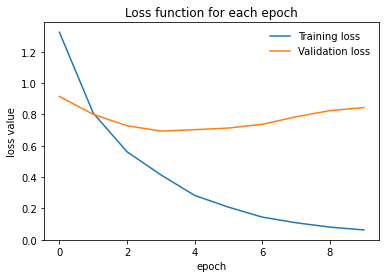

In [24]:
#Training and validation loss
plt.plot(train_loss, label='Training loss')
plt.plot(valid_loss, label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('loss value')
plt.title("Loss function for each epoch") 
plt.show()

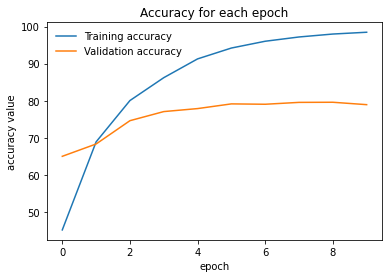

In [25]:
#Training and validation accuracy
plt.plot(train_acc, label='Training accuracy')
plt.plot(valid_acc, label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('epoch')
plt.ylabel('accuracy value')
plt.title("Accuracy for each epoch")
plt.show()

In [26]:
scheduler.state_dict()

{'_get_lr_called_within_step': False,
 '_last_lr': [0.00016806999999999998],
 '_step_count': 11,
 'base_lrs': [0.001],
 'gamma': 0.7,
 'last_epoch': 10,
 'step_size': 2,
 'verbose': False}

In [27]:
model1.state_dict

<bound method Module.state_dict of LSTM(
  (embedding): Embedding(9802, 128)
  (lstm): LSTM(128, 32, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)>

In [28]:
print(f'training loss on last epoch : {train_loss[-1]}')
print(f'validation loss on last epoch : {valid_loss[-1]}')
print('-'*20)
print(f'training accuracy on last epoch : {train_acc[-1]}')
print(f'validation accuracy on last epoch : {valid_acc[-1]}')

training loss on last epoch : 0.0623618938352876
validation loss on last epoch : 0.844019867832885
--------------------
training accuracy on last epoch : 98.45737855178736
validation accuracy on last epoch : 78.92673992673993


### Test the model

In [29]:
classes = ['اجتماعی', 'ادب و هنر', 'اقتصاد', 'سیاسی', 'علمی فرهنگی', 'ورزش']

In [30]:
def test(model1, test_loader):
  y_pred_test = []
  y_actual_test = []

  model1.eval()
  with torch.no_grad():
    n_true = 0
    n_total = 0
    n_class_correct = [0 for i in range(num_class)]
    n_class_sample = [0 for i in range(num_class)]
  
    for batch in test_loader:

      text, text_length = batch.preprocessing_text

      output = model1(text, text_length).squeeze()

      _, y_predtest = torch.max(output,1)

      n_true += (y_predtest == batch.label).sum()
      n_total += batch.label.size(0)

      for i in range(len(y_predtest)):
        y_pred_test.append(y_predtest[i])
        y_actual_test.append(batch.label[i].item())

      for i in range(len(y_predtest)):
        lb = int(batch.label[i].item())
        pred = y_predtest[i]
        if pred == lb:
          n_class_correct[lb] += 1
        n_class_sample[lb] += 1   

    print(f'accuracy of network on the {len(test_loader)} texts is : {(n_true/n_total) *100}')
  
    for i in range(len(classes)):
      acc = 100.0 * n_class_correct[i] / n_class_sample[i]
      print(f'Accuracy of {classes[i]}: {acc} %')
  
  return y_pred_test, y_actual_test

In [31]:
y_pred_test, y_actual_test = test(model1, test_loader)

accuracy of network on the 341 texts is : 78.98789978027344
Accuracy of اجتماعی: 81.35048231511254 %
Accuracy of ادب و هنر: 87.62541806020067 %
Accuracy of اقتصاد: 94.27860696517413 %
Accuracy of سیاسی: 61.47186147186147 %
Accuracy of علمی فرهنگی: 72.27722772277228 %
Accuracy of ورزش: 70.7112970711297 %


### Confusion Matrix

In [32]:
# libraries for show persian words in correct way(right to left)
from bidi.algorithm import get_display
from arabic_reshaper import reshape

def confusion_matrix(y_actual_test, y_pred_test):
  
  plt.figure(figsize = (10,7))
  ax= plt.subplot()
  cnf_matrix = metrics.confusion_matrix(y_actual_test, y_pred_test)
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels'); 
  ax.set_title('Confusion Matrix of model 1'); 
  class_names= classes
  # set persian names in correct way
  class_names = [get_display(reshape(label)) for label in class_names]
  ax.xaxis.set_ticklabels(class_names); ax.yaxis.set_ticklabels(class_names);
  plt.tight_layout()

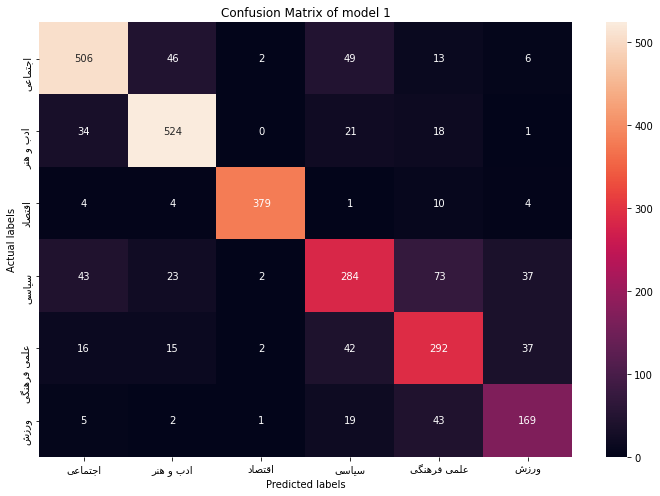

In [33]:
confusion_matrix(y_actual_test, y_pred_test)

In [34]:
print(classification_report(y_actual_test, y_pred_test))

              precision    recall  f1-score   support

         0.0       0.83      0.81      0.82       622
         1.0       0.85      0.88      0.86       598
         2.0       0.98      0.94      0.96       402
         3.0       0.68      0.61      0.65       462
         4.0       0.65      0.72      0.68       404
         5.0       0.67      0.71      0.69       239

    accuracy                           0.79      2727
   macro avg       0.78      0.78      0.78      2727
weighted avg       0.79      0.79      0.79      2727



## Get word vector from Embedding layer

In [37]:
# model1 = torch.load('/content/drive/MyDrive/AI-Internship/model1LSTM_hamshahri')

In [35]:
print(model1)

LSTM(
  (embedding): Embedding(9802, 128)
  (lstm): LSTM(128, 32, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)


In [44]:
boy =  TEXT.vocab.stoi['پسر']
child = TEXT.vocab.stoi['کودک']
fish = TEXT.vocab.stoi['ماهی']

print(f'index of boy : {boy}, index of child : {child}, index of fish : {fish}')

boy_embed = model1.embedding(torch.tensor(boy))
child_embed = model1.embedding(torch.tensor(child))
fish_embed = model1.embedding(torch.tensor(fish))

index of boy : 1139, index of child : 143, index of fish : 2107


In [47]:
print(f'boy_embed shape: {boy_embed.shape}')
print(f'child_embed shape : {child_embed.shape}')
print(f'fish_embed shape : {fish_embed.shape}')

boy_embed shape: torch.Size([128])
child_embed shape : torch.Size([128])
fish_embed shape : torch.Size([128])


In [48]:
boy_embed

tensor([-1.8142, -0.7879, -0.9591,  0.8549,  1.0381,  1.8010,  2.5400, -2.1065,
        -1.8167,  0.3648,  0.3850, -0.2662, -0.4410,  0.8093, -0.2465, -1.6679,
         0.0740, -0.2081,  0.1731,  0.7464,  0.5341, -0.7943,  0.6945, -0.5339,
         0.3576,  0.3231,  0.2664,  0.4831, -1.1682,  1.1127,  0.9054,  1.1607,
        -0.9642,  0.7982,  1.2884, -0.1596,  0.7608,  1.5504,  1.1328, -1.2832,
        -0.4766,  0.6810, -1.2899, -0.9407,  0.0349, -0.6688,  0.6697,  0.1013,
        -1.0894, -0.0245, -0.9701,  0.1136, -1.1523,  1.4279, -0.0913,  0.8113,
         0.0669,  0.8797,  1.1270,  2.0819,  0.3517,  2.2403,  1.1120,  1.5252,
         0.3403, -1.1239,  0.9155,  0.9142,  0.5975, -1.3170,  0.8972,  0.8846,
         0.3901,  0.4965, -1.2770,  1.3922, -0.8238, -1.8485, -1.7148,  1.3693,
        -0.1443,  0.4313,  0.6515,  1.5532, -0.0179, -0.1966,  1.3597, -0.4126,
         1.2492, -0.3331,  0.0112,  1.7747, -1.0775,  0.3730, -0.6187,  0.6480,
        -0.2482, -0.5701,  1.4460,  0.62

As we see in the following cell, dot product of boy and child is greater than dot product of fish and child. It means boy and child have more similarity than fish and child.

In [45]:
similarity_boy_child = torch.dot(boy_embed, child_embed)
similarity_boy_fish = torch.dot(fish_embed, boy_embed)

print(f'similarity of boy and child : {similarity_boy_child}')
print(f'similarity of boy and fish : {similarity_boy_fish}')

similarity of boy and child : 0.6667170524597168
similarity of boy and fish : -3.3541207313537598


## Word Embedding with Gensim

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')